In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from my_utils import load_data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
X, session_df, requests_df = load_data(csv_path='output.log', req_thres=5, normalize_feat=True)

LOADING THE DATASET...


Skipping line 601729: Expected 7 fields in line 601729, saw 23. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


DATASET HAS BEEN LOADED SUCESSFULLY!


In [4]:
X.head(10)

requests_count  \
ip              user_agent                                                           
1.81.122.235    Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...       -0.095735   
10.92.2.8       Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...       -0.031429   
100.92.35.41    Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...       -0.080424   
102.0.232.185   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       -0.068175   
102.0.232.220   Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...       -0.074299   
102.0.68.163    Mozilla/5.0 (Linux; Android 10; STK-LX1) AppleW...       -0.083486   
102.105.101.172 Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-G...       -0.000806   
                Mozilla/5.0 (Linux; Android 8.1.0; SM-G610F) Ap...        0.094122   
102.105.103.140 Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...       -0.055926   
102.105.139.132 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        5.045710   

                                                                    path_length_std  \
ip              user_agent                                                            
1.81.122.235    Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...         0.000000   
10.92.2.8       Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...         0.507875   
100.92.35.41    Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...         0.834847   
102.0.232.185   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...         0.516398   
102.0.232.220   Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...         0.267261   
102.0.68.163    Mozilla/5.0 (Linux; Android 10; STK-LX1) AppleW...         0.301511   
102.105.101.172 Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-G...         0.603451   
                Mozilla/5.0 (Linux; Android 8.1.0; SM-G610F) Ap...         0.671233   
102.105.103.140 Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...         0.307794   
102.105.139.132 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...         0.625527   

                                                                    4xx_percentage(%)  \
ip              user_agent                                                              
1.81.122.235    Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.102574   
10.92.2.8       Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...          -0.102574   
100.92.35.41    Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...          -0.102574   
102.0.232.185   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.102574   
102.0.232.220   Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...          -0.102574   
102.0.68.163    Mozilla/5.0 (Linux; Android 10; STK-LX1) AppleW...          -0.102574   
102.105.101.172 Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-G...          -0.102574   
                Mozilla/5.0 (Linux; Android 8.1.0; SM-G610F) Ap...          -0.102574   
102.105.103.140 Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...          -0.102574   
102.105.139.132 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.093590   

                                                                    3xx_percentage(%)  \
ip              user_agent                                                              
1.81.122.235    Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...          -0.718296   
10.92.2.8       Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-A...          -0.718296   
100.92.35.41    Mozilla/5.0 (Linux; Android 9; SM-A205F) AppleW...          -0.718296   
102.0.232.185   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          -0.718296   
102.0.232.220   Mozilla/5.0 (Linux; Android 11; SM-A505F) Apple...          -0.718296   
102.0.68.163    Mozilla/5.0 (Linux; Android 10; STK-LX1) AppleW...           1.721873   
102.105.101.172 Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-G...          -0.647660   
                Mozilla/5.0 (Linux; Android 8.1.0; SM-G610F) Ap...          -0.368185   
102.105.103.140 Mozilla/5.0 (Ma

In [10]:
X['is_bot'] = X['is_bot'].astype(int)
X['is_pc'] = X['is_pc'].astype(int)

to_model_cols = X.columns[:14]


X_train, X_test = train_test_split(X[to_model_cols], test_size=0.2, random_state=42)
X_test, X_val = train_test_split(X_test, test_size=0.4, random_state=42)

print('X_train shape: {}'.format(X_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (25232, 14)
X_val shape: (2524, 14)
X_test shape: (3785, 14)


In [12]:
X_train.columns

Index(['requests_count', 'path_length_std', '4xx_percentage(%)',
       '3xx_percentage(%)', 'HEAD_count(%)', 'image_count(%)',
       'total_response_length', 'mean_response_length', 'total_response_time',
       'mean_response_time', 'avg_path_count_norm', 'is_bot', 'is_pc',
       'avg_time_diff'],
      dtype='object')

# Auto encoder model

In [56]:
input_dim = X_train.shape[1] # the # features
encoding_dim = 8 # first layer
hidden_dim = int(encoding_dim / 2) #hidden layer


# model architecture
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])

autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 120       
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_35 (Dense)             (None, 14)                126       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


In [57]:
nb_epoch = 10
batch_size = 16

checkpoint_filepath = 'checkpoints/'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_val, X_val),
                    verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
1577/1577 [==============================] - 2s 675us/step - loss: 0.6237 - acc: 0.6662 - val_loss: 1.2626 - val_acc: 0.7326
Epoch 2/10
1577/1577 [==============================] - 1s 559us/step - loss: 0.5848 - acc: 0.7266 - val_loss: 1.2444 - val_acc: 0.7555
Epoch 3/10
1577/1577 [==============================] - 1s 548us/step - loss: 0.5052 - acc: 0.7533 - val_loss: 1.2336 - val_acc: 0.7655
Epoch 4/10
1577/1577 [==============================] - 1s 556us/step - loss: 0.5682 - acc: 0.7583 - val_loss: 1.2299 - val_acc: 0.7631
Epoch 5/10
1577/1577 [==============================] - 1s 547us/step - loss: 0.4809 - acc: 0.7608 - val_loss: 1.2266 - val_acc: 0.7655
Epoch 6/10
1577/1577 [==============================] - 1s 543us/step - loss: 0.4224 - acc: 0.7590 - val_loss: 1.2241 - val_acc: 0.7595
Epoch 7/10
1577/1577 [==============================] - 1s 622us/step - loss: 0.4526 - acc: 0.7595 - val_loss: 1.2220 - val_acc: 0.7623
Epoch 8/10
1577/1577 [==========================

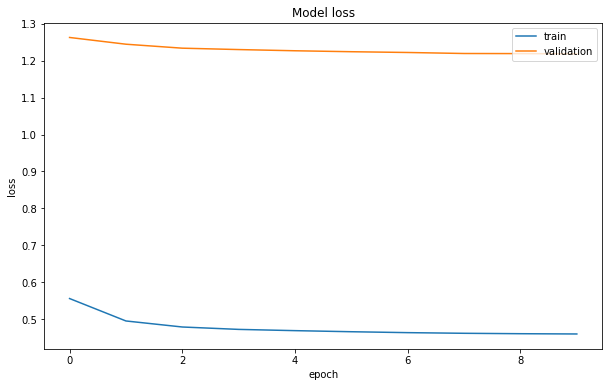

In [58]:
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [43]:
# load the best weights
autoencoder.load_weights(checkpoint_filepath)

preds = autoencoder.predict(X_test)

#get the error term
mse = np.mean(np.power(X_test - preds, 2), axis=1)

TypeError: 'NoneType' object is not callable

In [41]:
preds.shape

(3785, 14)